In [1]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd, rmsprop
#from autograd import scipy as sp
import numpy
import matplotlib.pyplot as plt
import sys

def trial1(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def p1(z):
    z1, z2 = z[:, 0], z[:, 1]
    first = (np.linalg.norm(z, 2, 1) - 2)/0.4
    exp1 = np.exp(-0.5*((z1 - 2)/0.6)**2)
    exp2 = np.exp(-0.5*((z1 + 2)/0.6)**2)
    u = 0.5*first**2 - np.log(exp1 + exp2)
    return np.exp(-u)

def p2(z):
    z1, z2 = z[:, 0], z[:, 1]
    w1 = lambda x: np.sin(2 * np.pi * x/4)
    u = 0.5 * ((z2 - w1(z1))/0.4) ** 2
    dummy = np.ones(u.shape) * 1e7
    u = np.where(np.abs(z1) <= 4, u, dummy)
    return np.exp(-u)

m = lambda x: -1 + np.log(1 + np.exp(x))
h = lambda x: np.tanh(x)
h_prime = lambda x: 1 - np.tanh(x)**2


def gradient_create(target, eps, dim_z, num_samples, K):

    def unpack_params(params):
        W = params[:K*dim_z].reshape(K,dim_z)
        U = params[K*dim_z:2*K*dim_z].reshape(K,dim_z)
        B = params[-K:]
        return W,U,B

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        W,U,B = unpack_params(params)
        z0 = np.random.multivariate_normal(np.zeros(dim_z), np.eye(dim_z),
                num_samples)
        z_prev = z0
        sum_log_det_jacob = 0.
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            affine = np.outer(h_prime(np.matmul(z_prev, w) + b), w)
            sum_log_det_jacob += np.log(eps + np.abs(1 + np.matmul(affine, u)))
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        #log_q_K = sp.stats.multivariate_normal.pdf(z0, np.zeros(2), np.eye(2))
        #- sum_log_det_jacob
        log_q_K = -0.5 * np.sum(np.log(2*np.pi) + z0**2, 1) - sum_log_det_jacob
        log_p = np.log(eps + target(z_K))
        return np.mean(log_q_K - log_p)

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

Iteration 0; Gradient mag: 1.656671170734979; Objective: 11.922609981912503


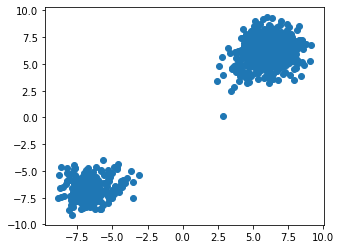

Iteration 100; Gradient mag: 0.7075241985853407; Objective: 11.850901590834367
Iteration 200; Gradient mag: 2.9846458503799567; Objective: 11.816162179728403
Iteration 300; Gradient mag: 3.9756828651441523; Objective: 11.98954498411508
Iteration 400; Gradient mag: 7.37569733913263; Objective: 11.894076592049018
Iteration 500; Gradient mag: 7.956395406891867; Objective: 11.776800368751513
Iteration 600; Gradient mag: 8.023272471626965; Objective: 11.811973527100065
Iteration 700; Gradient mag: 1.2510142730244411; Objective: 11.730846984855642
Iteration 800; Gradient mag: 4.741502349958598; Objective: 11.803104655781226
Iteration 900; Gradient mag: 3.472250156373081; Objective: 11.655212266212098
Iteration 1000; Gradient mag: 2.4770935881619134; Objective: 11.761534112268448
Iteration 1100; Gradient mag: 2.05038435351696; Objective: 11.720056491690688
Iteration 1200; Gradient mag: 15.940860863663278; Objective: 11.607216839233093
Iteration 1300; Gradient mag: 1.7112759115044616; Objectiv

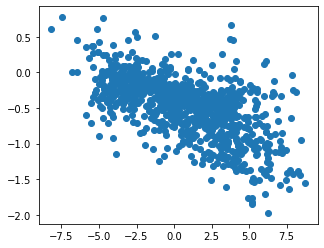

Iteration 5100; Gradient mag: 3.7286510369064505; Objective: -6.083552892304431
Iteration 5200; Gradient mag: 4.801040688635769; Objective: -5.976480611571907
Iteration 5300; Gradient mag: 2.912229314873451; Objective: -6.282987647363542
Iteration 5400; Gradient mag: 2.6303140759913455; Objective: -6.421825113616396
Iteration 5500; Gradient mag: 3.2519344879329166; Objective: -6.2152412711705765
Iteration 5600; Gradient mag: 2.6256739923916026; Objective: -6.641805250903459
Iteration 5700; Gradient mag: 3.5304959971205068; Objective: -6.4591225480176835
Iteration 5800; Gradient mag: 2.183524268449426; Objective: -6.978880304313988
Iteration 5900; Gradient mag: 2.518542293769054; Objective: -7.305677775090969
Iteration 6000; Gradient mag: 2.687197305139566; Objective: -7.090024192289958
Iteration 6100; Gradient mag: 3.1576413066707474; Objective: -6.501726787271346
Iteration 6200; Gradient mag: 2.7882131455001664; Objective: -7.412910408810219
Iteration 6300; Gradient mag: 2.52168019652

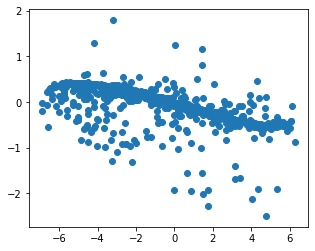

Iteration 10100; Gradient mag: 1.655064965310698; Objective: -10.490102420290388
Iteration 10200; Gradient mag: 1.8977631561337227; Objective: -10.83934857838389
Iteration 10300; Gradient mag: 2.1935643593493372; Objective: -10.498208041519208
Iteration 10400; Gradient mag: 2.2246103992807473; Objective: -10.355327968757644
Iteration 10500; Gradient mag: 2.2118718465763316; Objective: -10.956956842422883
Iteration 10600; Gradient mag: 1.8396440645803558; Objective: -10.826596978116767
Iteration 10700; Gradient mag: 1.5977746122868628; Objective: -11.063473660916442
Iteration 10800; Gradient mag: 1.6023897286142477; Objective: -10.718011418827443
Iteration 10900; Gradient mag: 1.90348858229231; Objective: -10.660097715491453
Iteration 11000; Gradient mag: 1.8606564920207056; Objective: -10.569921394612608
Iteration 11100; Gradient mag: 1.63290635873411; Objective: -10.510405409914545
Iteration 11200; Gradient mag: 2.9210074506288617; Objective: -10.815801391206824
Iteration 11300; Gradi

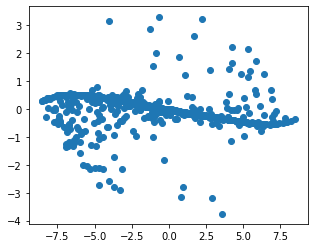

Iteration 15100; Gradient mag: 2.232143271729214; Objective: -12.903901213184986
Iteration 15200; Gradient mag: 2.3699133045110488; Objective: -13.215852009867643
Iteration 15300; Gradient mag: 3.440227761629765; Objective: -13.311558268639102
Iteration 15400; Gradient mag: 2.3444418536417118; Objective: -13.459112184064896
Iteration 15500; Gradient mag: 2.7134891826057617; Objective: -13.53260003861131
Iteration 15600; Gradient mag: 2.943921775619379; Objective: -13.654981997203821
Iteration 15700; Gradient mag: 3.1028644762490374; Objective: -12.968546946366153
Iteration 15800; Gradient mag: 1.8560038880010858; Objective: -13.75047466239639
Iteration 15900; Gradient mag: 2.7046506617551964; Objective: -13.692599259249803
Iteration 16000; Gradient mag: 4.090661842785963; Objective: -13.605917393952026
Iteration 16100; Gradient mag: 6.518073302670889; Objective: -14.1952275587456
Iteration 16200; Gradient mag: 2.436137530166854; Objective: -14.108129538921839
Iteration 16300; Gradient 

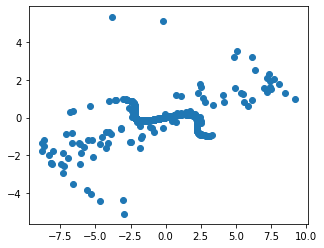

Iteration 20100; Gradient mag: 16.72541068485925; Objective: -20.859564010576257
Iteration 20200; Gradient mag: 8.70631917219087; Objective: -21.085788191124717
Iteration 20300; Gradient mag: 43.169456910655846; Objective: -20.85222804197166
Iteration 20400; Gradient mag: 37.799623625050415; Objective: -21.21807791317824
Iteration 20500; Gradient mag: 11.345059970344785; Objective: -21.136831891306407
Iteration 20600; Gradient mag: 39.13121375207572; Objective: -21.28188002130205
Iteration 20700; Gradient mag: 19.062693701336762; Objective: -21.306130727353832
Iteration 20800; Gradient mag: 33.28833739634187; Objective: -21.598800357213758
Iteration 20900; Gradient mag: 26.062270794450974; Objective: -21.350277384986256
Iteration 21000; Gradient mag: 16.079429430101282; Objective: -21.595554915502795
Iteration 21100; Gradient mag: 9.358201660687085; Objective: -21.649115867702598
Iteration 21200; Gradient mag: 39.310583057017546; Objective: -21.704078685550975
Iteration 21300; Gradient

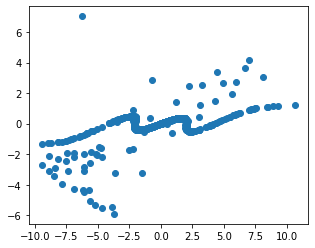

Iteration 25100; Gradient mag: 64.09221230758801; Objective: -22.311905525949374
Iteration 25200; Gradient mag: 65.16457892507518; Objective: -22.233393429272
Iteration 25300; Gradient mag: 92.97041053553994; Objective: -22.179997499565353
Iteration 25400; Gradient mag: 120.260713388885; Objective: -22.290946797942656
Iteration 25500; Gradient mag: 12.079210675767182; Objective: -22.162347493342203
Iteration 25600; Gradient mag: 94.53455181089234; Objective: -22.62657185939281
Iteration 25700; Gradient mag: 80.93538751611294; Objective: -22.51218073747068
Iteration 25800; Gradient mag: 45.61301432724622; Objective: -22.406504063023174
Iteration 25900; Gradient mag: 92.3134068959166; Objective: -22.66200904090639
Iteration 26000; Gradient mag: 54.28344054713332; Objective: -22.456407811821283
Iteration 26100; Gradient mag: 174.2798356361909; Objective: -22.32202693422783
Iteration 26200; Gradient mag: 57.912974898712484; Objective: -22.61916227780449
Iteration 26300; Gradient mag: 55.32

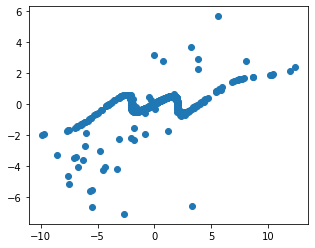

Iteration 30100; Gradient mag: 241.08002755561105; Objective: -23.059717708197443
Iteration 30200; Gradient mag: 98.55246715110128; Objective: -22.906618544837954
Iteration 30300; Gradient mag: 104.3944924683302; Objective: -23.2131833699316
Iteration 30400; Gradient mag: 76.67304885860379; Objective: -23.175122397197164
Iteration 30500; Gradient mag: 158.59916894759596; Objective: -23.081842827475604
Iteration 30600; Gradient mag: 71.84511426641721; Objective: -23.003144440552642
Iteration 30700; Gradient mag: 197.89196539325775; Objective: -22.933829769461497
Iteration 30800; Gradient mag: 122.30627110873438; Objective: -23.273368507021274
Iteration 30900; Gradient mag: 92.78529460717681; Objective: -23.377105479300813
Iteration 31000; Gradient mag: 133.3896187256251; Objective: -22.972306861617632
Iteration 31100; Gradient mag: 96.25254930522571; Objective: -23.347361612837645
Iteration 31200; Gradient mag: 313.47249215863474; Objective: -23.03364750928874
Iteration 31300; Gradient 

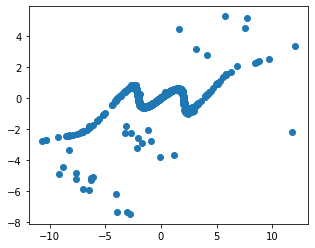

Iteration 35100; Gradient mag: 109.96631437230772; Objective: -24.15595939423736
Iteration 35200; Gradient mag: 84.71639751271758; Objective: -23.933264674730186
Iteration 35300; Gradient mag: 34.16117621067078; Objective: -23.754640702257735
Iteration 35400; Gradient mag: 227.32022415416867; Objective: -23.66296816299707
Iteration 35500; Gradient mag: 96.01925839073938; Objective: -23.65904980700164
Iteration 35600; Gradient mag: 136.1862113317056; Objective: -23.873368524964615
Iteration 35700; Gradient mag: 170.0390337696046; Objective: -24.244997357727982
Iteration 35800; Gradient mag: 33.78136154865423; Objective: -23.739706179590947
Iteration 35900; Gradient mag: 130.0011084170899; Objective: -23.736075752837376
Iteration 36000; Gradient mag: 117.75271426074555; Objective: -23.793143142084837
Iteration 36100; Gradient mag: 223.4984972514608; Objective: -23.889859361304335
Iteration 36200; Gradient mag: 230.18421530119755; Objective: -23.869284898346873
Iteration 36300; Gradient m

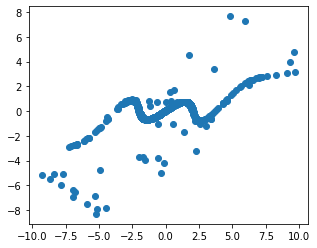

Iteration 40100; Gradient mag: 336.3558730944358; Objective: -24.741622135491454
Iteration 40200; Gradient mag: 136.74253419788613; Objective: -24.539552523189528
Iteration 40300; Gradient mag: 82.40648985500152; Objective: -24.627971577497878
Iteration 40400; Gradient mag: 269.68813991891506; Objective: -24.564862354609023
Iteration 40500; Gradient mag: 72.38351806142295; Objective: -24.39232286465619
Iteration 40600; Gradient mag: 90.03717956407381; Objective: -24.495328941063985
Iteration 40700; Gradient mag: 342.72016113007646; Objective: -24.357983066865515
Iteration 40800; Gradient mag: 122.86044705411626; Objective: -24.54883041556723
Iteration 40900; Gradient mag: 54.574921046515726; Objective: -24.445534071106888
Iteration 41000; Gradient mag: 291.0824433026617; Objective: -24.615290355607666
Iteration 41100; Gradient mag: 145.38752152046925; Objective: -24.69417960512058
Iteration 41200; Gradient mag: 500.88120733927576; Objective: -24.503445503745308
Iteration 41300; Gradien

In [2]:
K = 16
dim_z = 2
num_samples = 1000
num_iter = 45000
func = p2

objective, gradient, unpack_params = gradient_create(func, 1e-7, dim_z, num_samples, K)

objectives = []
def callback(params, t, g):
    if t%100 == 0:
        print("Iteration {}; Gradient mag: {}; Objective: {}".format(t,
            np.linalg.norm(gradient(params, t)), objective(params, t)))
        objectives.append(objective(params, t))
    if t%5000 == 0:
        W, U, B = unpack_params(params)
        z0 = np.random.randn(num_samples, dim_z)
        z_prev = z0
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        plt.figure(figsize=(5,4))
        plt.scatter(z_K[:,0], z_K[:,1])
        plt.show()


init_W = 1*np.ones((K, dim_z))
init_U = 1*np.ones((K, dim_z))
init_b = 1*np.ones((K))
init_params = np.concatenate((init_W.flatten(), init_U.flatten(), init_b.flatten()))

variational_params = adam(gradient, init_params, callback, num_iter, 1e-4)

In [3]:
W, U, B = unpack_params(variational_params)
z0 = np.random.randn(1000, dim_z)
z_prev = z0
for k in range(K):
    w, u, b = W[k], U[k], B[k]
    u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
    z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
z_K = z_prev

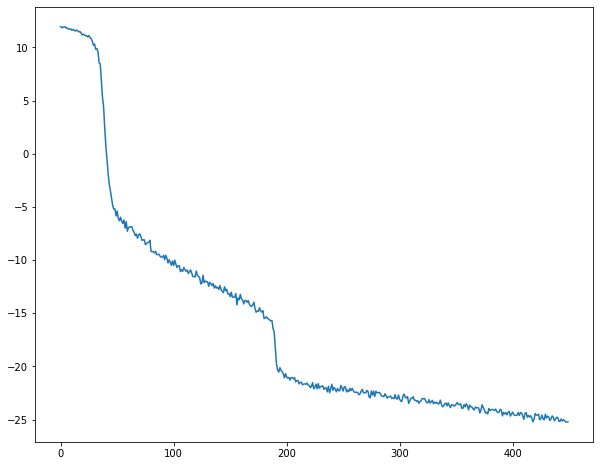

In [4]:
plt.figure(figsize=(10,8))
plt.plot(objectives)
plt.show()

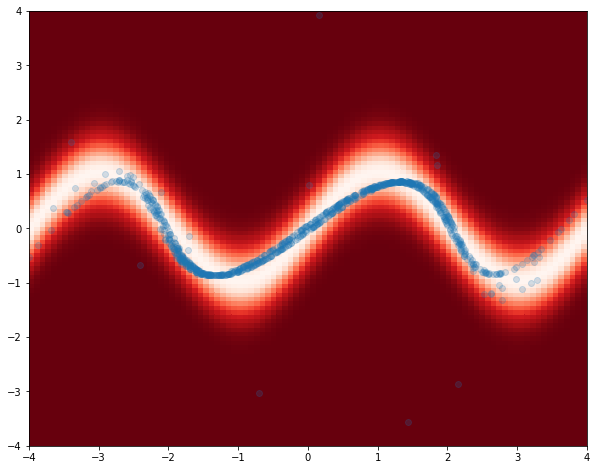

In [15]:
fig,ax=plt.subplots(1,1,figsize = (10,8))
nbins = 100
x, y = z0[:, 0], z0[:, 1]
xi, yi = numpy.mgrid[-4:4:nbins*1j, -4:4:nbins*1j]
zi = np.array([func(np.vstack([xi.flatten(), yi.flatten()])[:,i].reshape(-1,2)) for i in range(nbins**2)])
ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
plt.scatter(z_K[:,0], z_K[:,1], alpha=0.2)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.savefig('results/'+func.__name__+'/'+func.__name__+'_'+str(K)+'_'+str(num_iter)+'.png')
# plt.show()

In [6]:
B

array([0.60303357, 0.57833682, 0.70035717, 0.88984631, 0.92084512,
       0.56989429, 0.5459697 , 0.52093663, 0.51354735, 0.51819974,
       0.53182158, 0.59743917, 0.46923369, 0.42985651, 0.41619859,
       0.3434454 ])

In [14]:
p2.__name__

'p2'

In [8]:
U

array([[-0.57196855,  0.65404514],
       [ 0.11027675,  0.46953671],
       [ 0.16179938,  0.77642395],
       [ 0.41314203,  0.57368237],
       [ 0.94556569,  0.04357759],
       [ 0.7301594 ,  0.05774528],
       [ 0.79063268,  0.0223524 ],
       [ 1.27020588,  0.20311576],
       [ 1.50932582,  0.01975249],
       [ 1.76145831, -0.36905645],
       [ 1.86414148, -0.14087479],
       [ 2.25081098,  0.09670869],
       [ 2.5842768 ,  0.35976381],
       [ 3.02827083,  0.78187059],
       [ 4.76264487,  3.29049184],
       [ 1.16464401,  4.74776126]])